In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import learning_curve
# import XGBRegressor
# Load the trained model
best_model = joblib.load('../models/xgboost_model_best.joblib')

# Load the data and preprocess it
df = pd.read_csv('../data/processed/ml_ready_data.csv')
X = df.drop(columns=['universityRankingNum', 'uniqueID'])
y = df['universityRankingNum']


cv_scores_xgb = cross_val_score(best_model, X, y, cv=10, scoring='neg_mean_squared_error')  # Use 10-fold CV for better estimate
cv_rmse_xgb = np.sqrt(-cv_scores_xgb.mean())  # Convert negative MSE to RMSE
print(f"✅ XGBoost Cross-validated RMSE: {cv_rmse_xgb:.2f}")



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predict the values
xgb_y_pred = best_model.predict(X_test)

# Calculate RMSE and R² (Coefficient of Determination)
rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))
r2 = r2_score(y_test, xgb_y_pred)

# Evaluate XGBoost model performance

print(f"✅ RMSE: {rmse:.2f}")
# Calculate R² for XGBoost model
print(f"✅ XGBoost R²: {r2:.2f}")


✅ XGBoost Cross-validated RMSE: 0.95


ValueError: feature_names mismatch: ['ieltsMarks', 'toefl_ibt', 'minimumGPA', 'tuitionFeeUSD', 'ielts_toefl_interaction', 'gpa_tuition_interaction', 'ielts_squared', 'toefl_squared', 'country_AUS', 'country_CAD', 'country_NZ', 'country_UK', 'country_US', 'courseLevelSimplified_Postgraduate', 'courseLevelSimplified_Undergraduate'] ['ieltsMarks', 'toefl_ibt', 'minimumGPA', 'tuitionFeeUSD', 'country_AUS', 'country_CAD', 'country_NZ', 'country_UK', 'country_US', 'courseLevelSimplified_Postgraduate', 'courseLevelSimplified_Undergraduate']
expected gpa_tuition_interaction, toefl_squared, ielts_toefl_interaction, ielts_squared in input data

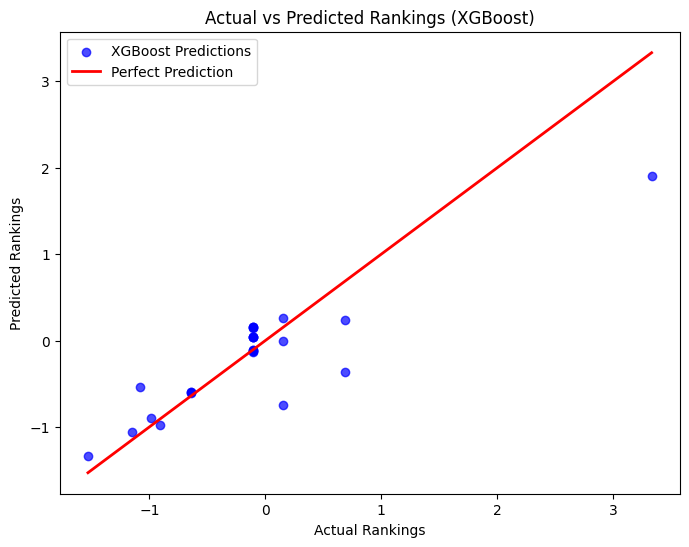

In [2]:
# Step 3: Visualization

# Actual vs Predicted Plot for XGBoost
plt.figure(figsize=(8, 6))
plt.scatter(y_test, xgb_y_pred, alpha=0.7, color='blue', label='XGBoost Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Rankings')
plt.ylabel('Predicted Rankings')
plt.title('Actual vs Predicted Rankings (XGBoost)')
plt.legend()
plt.show()

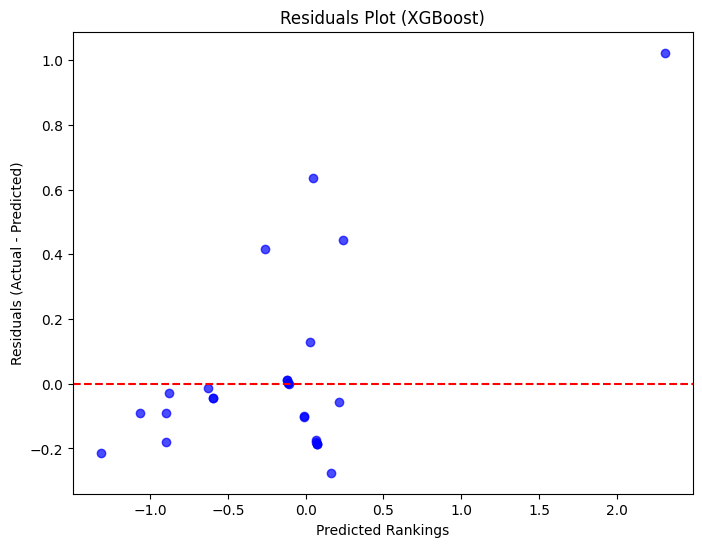

In [3]:
# Residuals Plot for XGBoost
xgb_residuals = y_test - xgb_y_pred
plt.figure(figsize=(8, 6))
plt.scatter(xgb_y_pred, xgb_residuals, alpha=0.7, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Rankings')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot (XGBoost)')
plt.show()

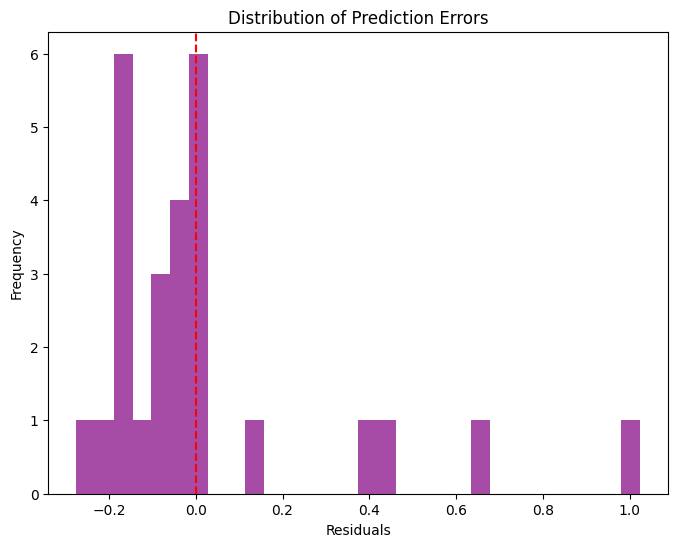

In [4]:
plt.figure(figsize=(8, 6))
plt.hist(xgb_residuals, bins=30, color='purple', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

This plot shows the residuals (the difference between actual and predicted values). It helps to check for patterns in the model’s errors.

Ideally, residuals should be randomly scattered around 0, indicating that the model doesn't have systematic errors.

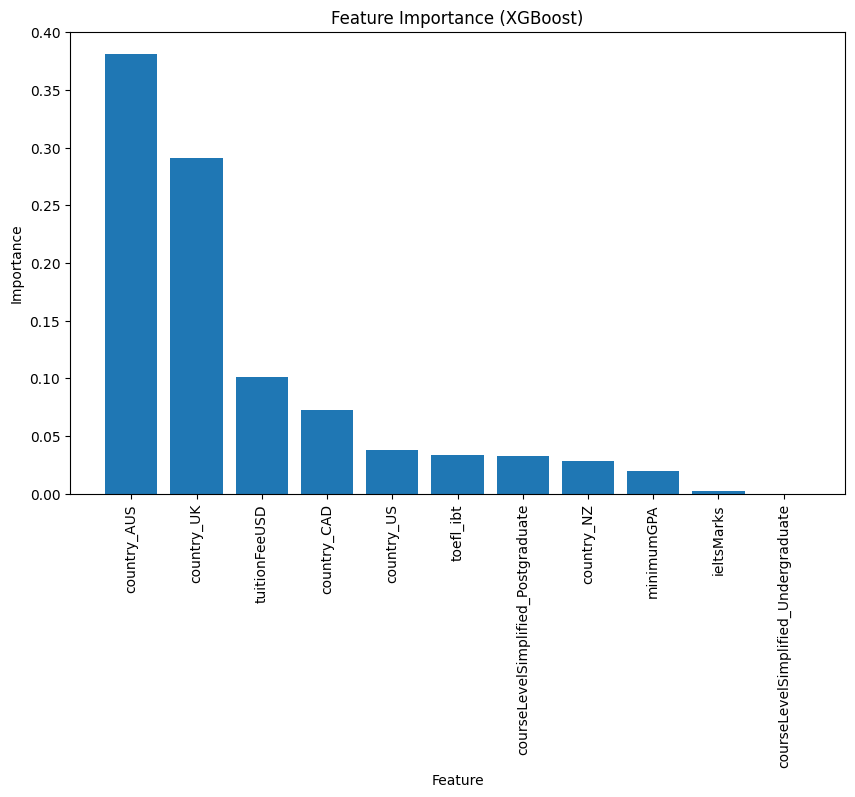

In [7]:
# Feature Importance Plot for XGBoost
xgb_importances = best_model.feature_importances_
indices_xgb = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(xgb_importances)), xgb_importances[indices_xgb], align='center')
plt.xticks(range(len(xgb_importances)), np.array(X.columns)[indices_xgb], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance (XGBoost)')
plt.show()

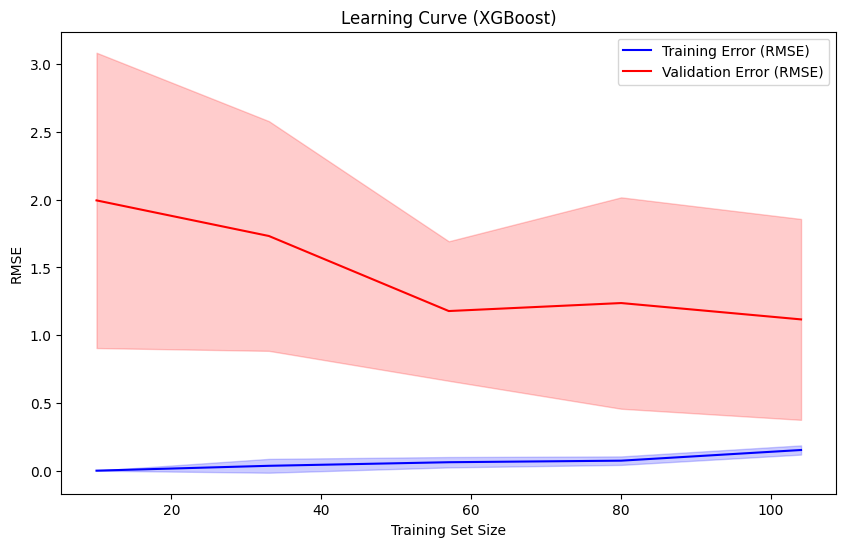

In [8]:

# --- Learning Curve Visualization ---
# Generate learning curve data for XGBoost
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

# Calculate the mean and standard deviation for train and test scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -train_mean, label='Training Error (RMSE)', color='blue')
plt.plot(train_sizes, -test_mean, label='Validation Error (RMSE)', color='red')
plt.fill_between(train_sizes, -train_mean + train_std, -train_mean - train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, -test_mean + test_std, -test_mean - test_std, color='red', alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve (XGBoost)')
plt.legend(loc='best')
plt.show()

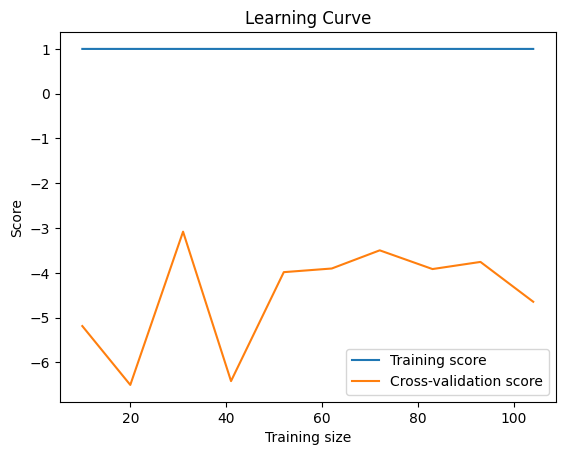

In [24]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    xgb.XGBRegressor(random_state=42),
    X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

You can visualize how the model’s training error and validation error change as the training set size increases. This helps to diagnose overfitting and underfitting.

Interpretation: If the model's training score keeps improving while the validation score stagnates or worsens, this indicates overfitting.